# Instructions

Ce notebook ne doit contenir que votre script servant à l'entrainement de votre modèle. Nous devons pouvoir l'exécuter en cliquant sur *Exécution -> Tout exécuter*.

Veuillez également ajouter des commentaires dans votre code pour expliquer ce que vous faites. N'hésitez pas à ajouter des blocs de textes (cliquez sur le bouton *+ Texte* en dessous du menu) pour ajouter plus d'explications.

Vous devrez déposer sur Moodle une archive au format .zip contenant un dossier avec vos noms.

Dans ce dossier, nous devons retrouver les deux notebooks (training et testing) ainsi qu'un nouveau dossier *models* contenant les poids de vos modèles entrainés, et si nécessaire un dossier *datasets* contenant d'autres données utilisée pour effectuer l'apprentissage de vos modèles (données obtenues par récupération sur le web "web scraping"  ou bien augmentation de données "data augmentation"). Si vous effectuez de l'augmentation de données, fournissez aussi le code pour la réaliser dans le notebook.

# Fichier d'entraînement et de test 

Pour le fichier d'entraînement il y a celui de base fourni qui est "fake_train.csv" et celui que j'ai fait moi même (translated_news_cleaned_with_train.csv) pour augmenter les données dont la méthode de data augmentation est détaillée dans le rapport.

In [1]:
# Charger les données :
train_file_path = 'translated_news_cleaned_with_train_10000.csv'
#train_file_path = 'translated_news_cleaned_with_train_3000.csv'
#train_file_path = 'fake_train.csv'
test_file_path = 'fake_test.csv'

# Imporation des librairies 

In [2]:
import pandas as pd
from nltk.corpus import stopwords
import nltk

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Téléchargement des Stop Words en français

Les stop words sont des mots courant comme "et", "le", "la",... que l'on supprime pour se concentré sur les autes mots 

In [3]:
# Télécharger les stop words en français
nltk.download('stopwords')
french_stop_words = stopwords.words('french')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolasmelaerts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Extraction des données 

On a besoin des colonnes "data" et "label" pour l'entraînement et le test

In [4]:
# Charger les fichiers CSV en spécifiant les colonnes à utiliser
ds_train = pd.read_csv(train_file_path, usecols=[1, 2], names=['data', 'label'], header=0)
ds_test = pd.read_csv(test_file_path, usecols=[1, 2], names=['data', 'label'], header=0)

# Extraire les data et les labels
X_train = ds_train['data']
y_train = ds_train['label']

X_test = ds_test['data']
y_test = ds_test['label']

In [5]:
print('Training data shape:', X_train.shape)
print('Testing data shape:', X_test.shape)

Training data shape: (10334,)
Testing data shape: (486,)


# Liste des modèles et grille de paramètres 

On va tenter de trouver le meilleur algorithme pour notre tâche.
On teste sur plusieurs paramètres pour explorer différentes configurations

In [6]:
# Liste des modèles
models = {
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'RidgeClassifier': RidgeClassifier()
}

param_grid = {
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf'],
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20],
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'max_iter': [50, 100],
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree'],
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 7],
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 0.5],
        'algorithm': ['SAMME'],
    },
    'Extra Trees': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 10, 20],
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'criterion': ['gini', 'entropy'],
    },
    'RidgeClassifier': {
        'alpha': [0.1, 1, 10],
    }
}



# Evaluation des modèles 

On évalue les modèles avec différent vectoriseur en utilisant une gridsearchCV pour trouver les meilleurs hyperparamètres 

In [7]:
def evaluate_models_with_vectorizers(models, param_grid, vectorizers):
    results = {}

    for vectorizer_name, (X_train_vec, X_test_vec) in vectorizers.items():
        print(f"\nTesting with {vectorizer_name}...")

        for model_name, model in models.items():
            print(f"GridSearchCV du modèle : {model_name}")

            # Vérifier si le modèle a une grille de paramètres définie
            if model_name not in param_grid:
                print(f"Aucun paramètre défini pour {model_name}. Skipping.")
                continue

            # Paramètres à tester pour ce modèle
            grid_search = GridSearchCV(
                model, param_grid[model_name], cv=5, scoring='accuracy', n_jobs=-1
            )

            # Entraînement avec GridSearchCV
            grid_search.fit(X_train_vec, y_train)

            # Récupérer les meilleurs paramètres et le meilleur score
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_

            # Enregistrer les résultats
            results[(model_name, vectorizer_name)] = {
                'best_params': best_params,
                'best_score': best_score
            }

    return results

# Lancement de l'algorithme pour trouver le meilleur modèle avec les meilleurs hyperparamètres et le meilleur vectoriseur 

In [8]:
# Création des vectoriseurs
count_vectorizer = CountVectorizer(stop_words=french_stop_words, max_features=5000, strip_accents='unicode')
tfidf_vectorizer = TfidfVectorizer(stop_words=french_stop_words, max_features=5000, strip_accents='unicode')
hashing_vectorizer = HashingVectorizer(stop_words=french_stop_words, n_features=5000, strip_accents='unicode')

tagged_docs = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(X_train)]
doc2vec_model = Doc2Vec(tagged_docs, vector_size=100, window=5, min_count=2)
X_train_d2v = [doc2vec_model.infer_vector(text.split()) for text in X_train]
X_test_d2v = [doc2vec_model.infer_vector(text.split()) for text in X_test]

# Dictionnaire des vectoriseurs
vectorizers = {
    'CountVectorizer': (count_vectorizer.fit_transform(X_train), count_vectorizer.transform(X_test)),
    'TF-IDF': (tfidf_vectorizer.fit_transform(X_train), tfidf_vectorizer.transform(X_test)),
    'HashingVectorizer': (hashing_vectorizer.fit_transform(X_train), hashing_vectorizer.transform(X_test)),
    'Doc2Vec': (X_train_d2v, X_test_d2v)
}

# Évaluation des modèles
results = evaluate_models_with_vectorizers(models, param_grid, vectorizers)


/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fumes', 'futes', 'meme'] not in stop_words.
  warnings.warn(



Testing with CountVectorizer...
GridSearchCV du modèle : SVM
GridSearchCV du modèle : Random Forest
GridSearchCV du modèle : Logistic Regression


/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

GridSearchCV du modèle : KNN


/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaer

GridSearchCV du modèle : Gradient Boosting
GridSearchCV du modèle : AdaBoost
GridSearchCV du modèle : Extra Trees
GridSearchCV du modèle : Decision Tree
GridSearchCV du modèle : RidgeClassifier

Testing with TF-IDF...
GridSearchCV du modèle : SVM
GridSearchCV du modèle : Random Forest
GridSearchCV du modèle : Logistic Regression


/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV du modèle : KNN


/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaer

GridSearchCV du modèle : Gradient Boosting
GridSearchCV du modèle : AdaBoost
GridSearchCV du modèle : Extra Trees
GridSearchCV du modèle : Decision Tree
GridSearchCV du modèle : RidgeClassifier

Testing with HashingVectorizer...
GridSearchCV du modèle : SVM
GridSearchCV du modèle : Random Forest
GridSearchCV du modèle : Logistic Regression


/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV du modèle : KNN


/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/nicolasmelaer

GridSearchCV du modèle : Gradient Boosting
GridSearchCV du modèle : AdaBoost
GridSearchCV du modèle : Extra Trees
GridSearchCV du modèle : Decision Tree
GridSearchCV du modèle : RidgeClassifier

Testing with Doc2Vec...
GridSearchCV du modèle : SVM
GridSearchCV du modèle : Random Forest
GridSearchCV du modèle : Logistic Regression


/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

GridSearchCV du modèle : KNN
GridSearchCV du modèle : Gradient Boosting
GridSearchCV du modèle : AdaBoost
GridSearchCV du modèle : Extra Trees
GridSearchCV du modèle : Decision Tree
GridSearchCV du modèle : RidgeClassifier


# Pour analyser les résultats on plot les scores en fonction des vectoriseurs et puis chaque meilleur score de chaque modèle

In [9]:
def plot_results(results):
    data = []
    for (model_name, vectorizer_name), result in results.items():
        best_score = result['best_score']
        data.append({'Model': model_name, 'Vectorizer': vectorizer_name, 'Score': best_score})

    df_results = pd.DataFrame(data)

    pivot_results = df_results.pivot(index='Model', columns='Vectorizer', values='Score')

    # Bar plot : Scores des modèles pour chaque vectoriseur
    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_results, x='Model', y='Score', hue='Vectorizer', palette='viridis')
    plt.title('Scores des modèles selon les vectoriseurs')
    plt.ylabel('Score (Accuracy)')
    plt.xticks(rotation=45)
    plt.legend(title='Vectorizer', loc='upper right')
    plt.tight_layout()
    plt.show()

    # Heatmap : Matrice de comparaison des scores
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_results, annot=True, fmt=".4f", cmap='coolwarm', cbar=True)
    plt.title('Matrice des scores des modèles par vectoriseur')
    plt.ylabel('Model')
    plt.xlabel('Vectorizer')
    plt.tight_layout()
    plt.show()


# Fonction pour trouver le meilleur modèle parmis tous ceux entraîner

In [10]:
def search_best_model(results):
    best_model_name = None
    best_vectorizer_name = None
    best_score_overall = -float('inf')
    best_params_overall = None

    # Parcourir les résultats pour trouver le meilleur score
    for (model_name, vectorizer_name), result in results.items():
        best_score = result['best_score']
        best_params = result['best_params']

        if best_score > best_score_overall:
            best_model_name = model_name
            best_vectorizer_name = vectorizer_name
            best_score_overall = best_score
            best_params_overall = best_params

    # Retourner les résultats du meilleur modèle
    return best_model_name, best_vectorizer_name, best_score_overall, best_params_overall



# Affichage du meilleur modèle

In [11]:
best_model_name, best_vectorizer_name, best_score_overall, best_params_overall = search_best_model(results)

# Afficher les résultats pour vérification
print(f"Meilleur modèle : {best_model_name}")
print(f"Meilleur vectoriseur : {best_vectorizer_name}")
print(f"Meilleur score : {best_score_overall}")
print(f"Meilleurs paramètres : {best_params_overall}")

Meilleur modèle : SVM
Meilleur vectoriseur : TF-IDF
Meilleur score : 0.9115321623951917
Meilleurs paramètres : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


# Plot des résultats

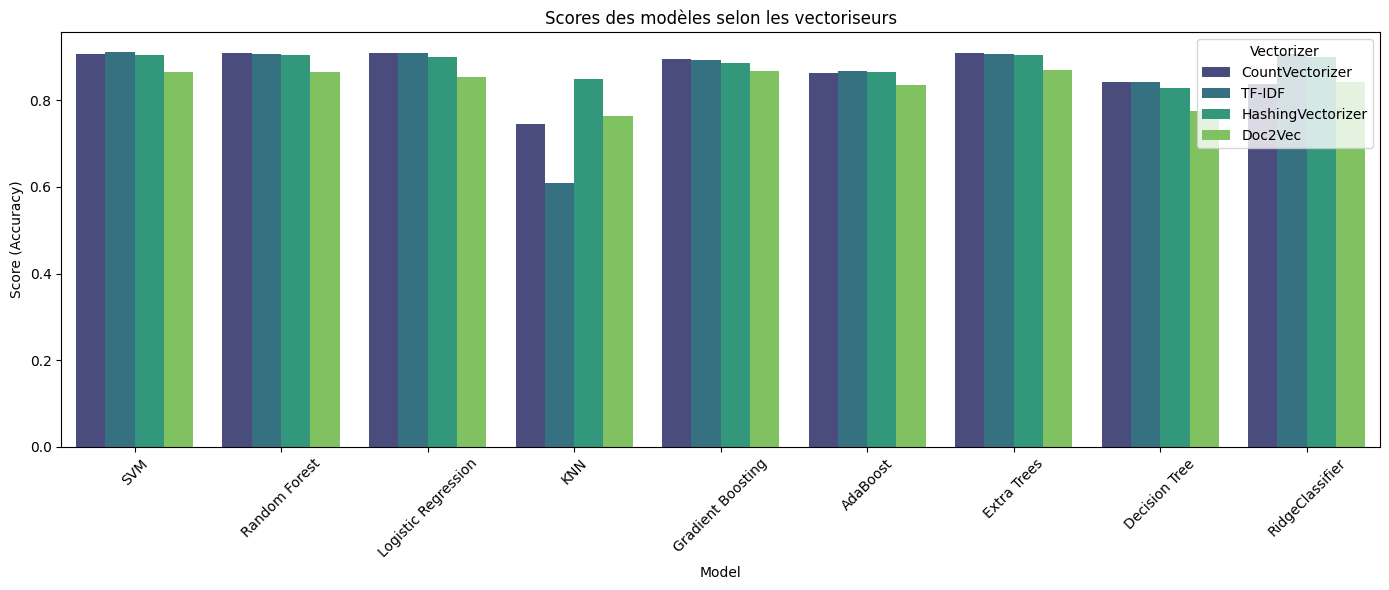

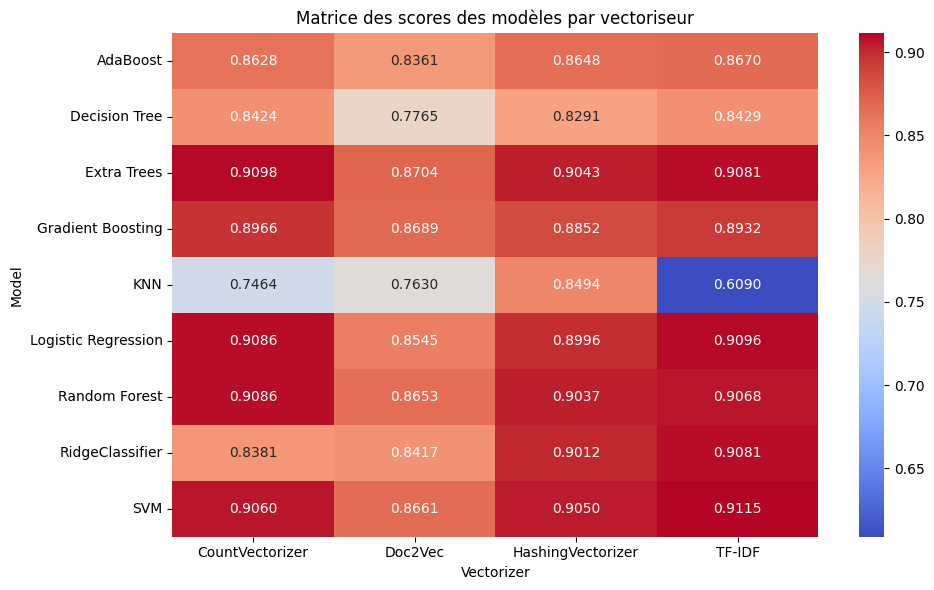

In [12]:
plot_results(results)

# Export du meilleur modèle et vectoriseur

In [13]:
# Entrainer le meilleur modèle avec les meilleurs paramètres
models[best_model_name].set_params(**best_params_overall)

fitted_model = models[best_model_name].fit(vectorizers[best_vectorizer_name][0], y_train)

# Exporter le modèle
joblib.dump(fitted_model, 'best_model.pkl')

# Exporter le vectorizer
joblib.dump(tfidf_vectorizer, 'best_vectorizer.pkl')

print(f"\nExportés avec succès !")



Exportés avec succès !


# Affichage de l'accuracy

In [14]:
# Charger le modèle et le vectorizer exportés
loaded_model = joblib.load('best_model.pkl')
loaded_vectorizer = joblib.load('best_vectorizer.pkl')

# Transformer les données de test avec le vectorizer chargé
X_test_vectorised = loaded_vectorizer.transform(X_test)

# Faire des prédictions avec le modèle chargé
y_pred_loaded = loaded_model.predict(X_test_vectorised)

# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred_loaded)
print(f"L'accuracy du modèle sur les données de test est : {accuracy:.4f}")

/Users/nicolasmelaerts/.pyenv/versions/3.10.1/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fumes', 'futes', 'meme'] not in stop_words.
  warnings.warn(


L'accuracy du modèle sur les données de test est : 0.9383
